**Importando as biblotecas**

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
)

# Classificador referência
from sklearn.dummy import DummyClassifier

# Estudo lineares
from sklearn.linear_model import LogisticRegression

# Estudo árvores
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# Estudo KNN
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

sns.set_theme(palette="bright")

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V23,V24,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.403993,0.251412,-0.018307,-0.110474,0.066928,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.145783,-0.069083,-0.225775,0.101288,-0.339846,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.232622,-0.208038,-0.108300,-0.190321,-1.175575,-0.221929,0.062723,0.061458,123.50,0
3,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.803487,0.408542,-0.009431,-0.137458,0.141267,0.502292,0.219422,0.215153,69.99,0
4,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.033194,0.084968,-0.208254,-0.026398,-0.371427,0.105915,0.253844,0.081080,3.67,0


**Pré-processamento e Escalonamento das Variáveis**

Após a etapa de Análise Exploratória dos Dados (EDA), iniciou-se o processo de pré-processamento, com foco na preparação das variáveis para a modelagem. Como o conjunto de dados possui variáveis com diferentes escalas, distribuições e presença de outliers, foram adotadas **estratégias de escalonamento distintas**, de acordo com as características de cada feature.

- **`Time`**  
Escalonada utilizando **MinMaxScaler**, por representar uma variável temporal contínua.
 
- **`Amount`**  
Transformada utilizando **PowerTransformer**, com o objetivo de reduzir assimetria e aproximar a distribuição de uma forma mais próxima da normalidade.

- **Demais variáveis (`V1` a `V28`)**  
Escalonadas com **RobustScaler**, por apresentarem outliers e distribuições assimétricas.


In [3]:
coluna_min_max = ["Time"]

coluna_power_transformer = ["Amount"]

target = ["Class"]

colunas_robust_scaler = [
    coluna for coluna in df.columns if coluna not in (
        coluna_min_max + coluna_power_transformer + target
    )
]

colunas_robust_scaler

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V23',
 'V24',
 'V26',
 'V27',
 'V28']

**Separação das Variáveis de Entrada e Alvo**

A variável alvo foi removida do conjunto de features e armazenada separadamente, conforme o código abaixo:

In [4]:
X = df.drop(columns=target)
y = df[target].values.ravel()

**Pipeline de Pré-processamento**

Para aplicar diferentes transformações a grupos específicos de variáveis de forma organizada e segura, foi utilizado o `ColumnTransformer` da biblioteca scikit-learn.

**MinMaxScaler**
- Aplicado à variável `Time`
- Normaliza os valores para o intervalo [0, 1]

**RobustScaler**
- Aplicado às variáveis `V1` a `V28`
- Reduz a influência de outliers, utilizando mediana e intervalo interquartil

**PowerTransformer**
- Aplicado à variável `Amount`
- Reduz assimetria e estabiliza a variância

O uso do `ColumnTransformer` permite aplicar transformações distintas de forma consistente e reproduzível, além de facilitar a integração com pipelines de modelagem.


In [5]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("min_max", MinMaxScaler(), coluna_min_max),
        ("standard", RobustScaler(), colunas_robust_scaler),
        ("power_transform", PowerTransformer(), coluna_power_transformer),
    ]
)

In [6]:
scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]
scale_pos_weight

np.float64(520.5040650406504)

**Modelos Avaliados**

Com o objetivo de comparar diferentes abordagens de classificação, foram definidos múltiplos modelos, variando desde baselines simples até algoritmos mais sofisticados.



In [7]:
classificadores = {
    "DummyClassifier": {
        "preprocessor": None,
        "classificador": DummyClassifier(strategy="stratified"),
    },
    "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression(class_weight="balanced"),
    },
    "DecisionTreeClassifier": {
        "preprocessor": None,
        "classificador": DecisionTreeClassifier(class_weight="balanced"),
    },
    "LGBMClassifier": {
        "preprocessor": None,
        "classificador": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            scale_pos_weight=scale_pos_weight,
        ),
    },
    "XGBClassifier": {
        "preprocessor": None,
        "classificador": XGBClassifier(
            random_state=RANDOM_STATE, n_jobs=-1, scale_pos_weight=scale_pos_weight
        ),
    },
    "KNeighborsClassifier": {
        "preprocessor": preprocessamento,
        "classificador": KNeighborsClassifier(),
    },
}

**Estratégia de Validação**

Para avaliar os modelos de forma robusta e reduzir viés na estimativa de desempenho, foi utilizada **validação cruzada estratificada**.

In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [9]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

C:\Users\108618\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\108618\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\108618\AppData\Local\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\108618\AppData\Local\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, execut

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.061551,0.048594,0.996395,0.499151,0.0,0.0,0.0,0.504155,0.001994,0.110145
1,DummyClassifier,0.063857,0.056354,0.995732,0.498819,0.0,0.0,0.0,0.499082,0.00191,0.120211
2,DummyClassifier,0.066154,0.041363,0.996103,0.504097,0.009901,0.009615,0.010204,0.499014,0.00191,0.107517
3,DummyClassifier,0.085946,0.035067,0.996083,0.499004,0.0,0.0,0.0,0.498789,0.001929,0.121012
4,DummyClassifier,0.07042,0.044026,0.996473,0.50424,0.010929,0.011905,0.010101,0.499014,0.001929,0.114446
5,LogisticRegression,2.496778,0.127191,0.98328,0.935609,0.168605,0.093148,0.887755,0.985234,0.608503,2.623969
6,LogisticRegression,2.630025,0.122825,0.977785,0.958317,0.138973,0.075041,0.938776,0.987455,0.731336,2.75285
7,LogisticRegression,2.124379,0.118824,0.978545,0.958698,0.143191,0.077506,0.938776,0.978128,0.800227,2.243203
8,LogisticRegression,2.018908,0.119591,0.981292,0.940221,0.156415,0.085659,0.89899,0.97971,0.687418,2.138499
9,LogisticRegression,1.804392,0.112432,0.978252,0.95382,0.141538,0.076603,0.929293,0.981516,0.738762,1.916825


**Avaliação dos Modelos**

Após a validação cruzada estratificada, os resultados obtidos em cada fold foram consolidados por modelo, calculando-se a média das métricas de desempenho.


In [10]:
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.069586,0.045081,0.996157,0.501062,0.004166,0.004304,0.004061,0.500011,0.001934,0.114666
LGBMClassifier,1.150263,0.110713,0.938261,0.910207,0.074547,0.039382,0.882045,0.905443,0.035513,1.260975
DecisionTreeClassifier,12.440561,0.056633,0.999146,0.877863,0.772645,0.790788,0.756112,0.877863,0.598323,12.497195
LogisticRegression,2.214896,0.120173,0.979831,0.949333,0.149744,0.081591,0.918718,0.982408,0.713249,2.335069
KNeighborsClassifier,0.95209,54.332116,0.999462,0.882054,0.844453,0.945503,0.764193,0.928754,0.818819,55.284207
XGBClassifier,1.610427,0.094829,0.999622,0.923736,0.895317,0.949773,0.847557,0.986293,0.889975,1.705256


**Resultados dos Modelos**

A tabela apresenta a média das métricas obtidas por meio de validação cruzada estratificada (5 folds) para cada modelo avaliado.

O XGBoost apresentou o melhor desempenho geral entre os modelos avaliados.
- Maior Average Precision (PR-AUC)
- Alto Recall e F1-score
- Excelente equilíbrio entre precisão e sensibilidade

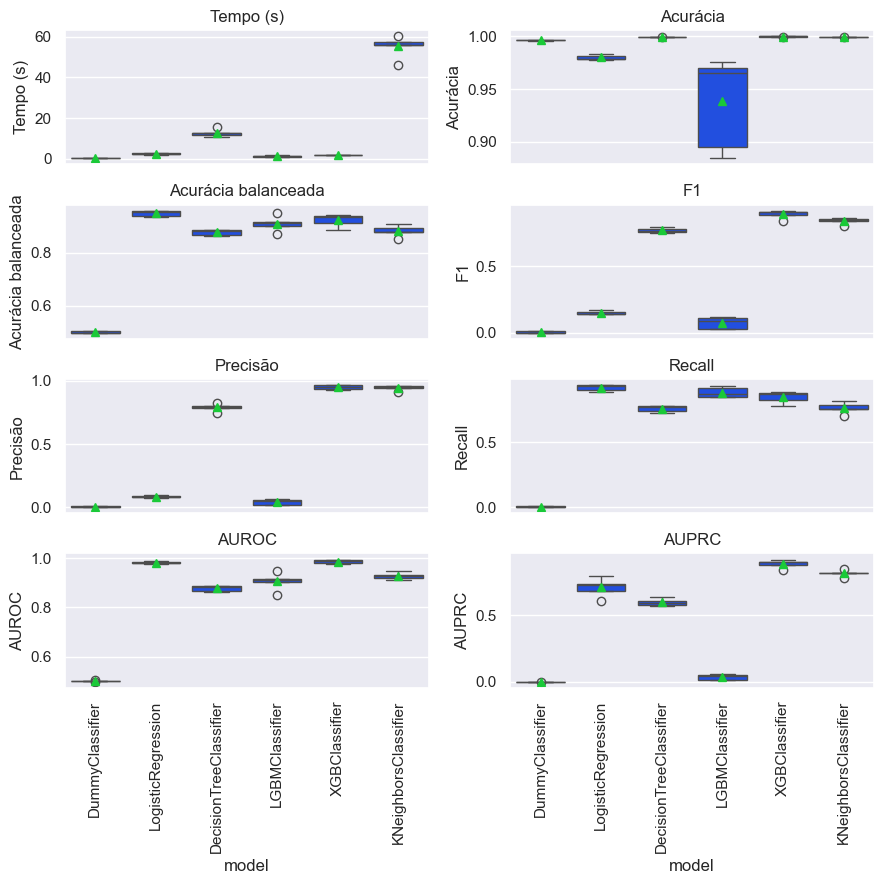

In [11]:
plot_comparar_metricas_modelos(df_resultados)

In [12]:
classificadores["XGBClassifier"]

{'preprocessor': None,
 'classificador': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=-1, num_parallel_tree=None, ...)}

**Treinamento e Validação do Modelo Selecionado (XGBoost)**

Após a comparação entre os modelos, o **XGBoost** foi selecionado para uma validação mais focada, por apresentar o melhor desempenho geral (especialmente em **Average Precision / PR-AUC**), mantendo bom equilíbrio entre **Recall**, **Precision** e custo computacional.

In [13]:
treinar_e_validar_modelo_classificacao(
    X, y, kf, **classificadores["XGBClassifier"]
)

{'fit_time': array([1.63434434, 1.59504414, 1.6483748 , 1.64124513, 1.80369282]),
 'score_time': array([0.0942409 , 0.09427619, 0.09487844, 0.10024738, 0.11313391]),
 'test_accuracy': array([0.99945436, 0.99966872, 0.99970769, 0.99961026, 0.99966872]),
 'test_balanced_accuracy': array([0.88769653, 0.94381898, 0.93874622, 0.91411213, 0.93430438]),
 'test_f1': array([0.84444444, 0.91099476, 0.9197861 , 0.89130435, 0.91005291]),
 'test_precision': array([0.92682927, 0.93548387, 0.96629213, 0.96470588, 0.95555556]),
 'test_recall': array([0.7755102 , 0.8877551 , 0.87755102, 0.82828283, 0.86868687]),
 'test_roc_auc': array([0.97754795, 0.99096101, 0.98851886, 0.97993978, 0.99449895]),
 'test_average_precision': array([0.84433049, 0.90305055, 0.89986844, 0.88100103, 0.92162321])}

**Importância das Variáveis (Permutation Importance)**

Após selecionar o XGBoost como modelo de melhor desempenho, foi realizada uma análise de interpretabilidade usando **Permutation Importance**.

Como o problema é altamente desbalanceado, a importância foi medida com base em **Average Precision (PR-AUC)**, pois essa métrica é mais informativa do que acurácia para avaliar a classe minoritária (fraudes).

Observa-se que variáveis como **V14** e **V4** se destacam como as mais relevantes para o modelo, apresentando o maior decréscimo no PR-AUC quando permutadas. A variável **Amount** também aparece entre as mais importantes, sugerindo que o valor da transação contribui de forma significativa para a identificação de fraudes, em conjunto com as variáveis transformadas (`V*`).


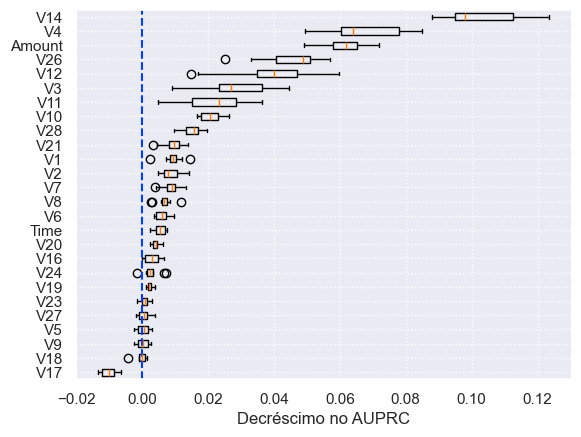

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE, stratify=y
)

clf = classificadores["XGBClassifier"]["classificador"]

clf.fit(X_train, y_train)

perm_imp = permutation_importance(
    clf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="average_precision"
)

fig, ax = plt.subplots()

ordem = perm_imp.importances_mean.argsort()

ax.boxplot(perm_imp.importances[ordem].T, vert=False, tick_labels=X.columns[ordem])
ax.axvline(x=0, linestyle="--")
ax.set_xlabel("Decréscimo no AUPRC")
ax.grid(True, linestyle=":")

plt.show()

**Seleção de Variáveis**

Com base na análise de importância das variáveis utilizando **Permutation Importance**, foi realizada uma etapa de seleção de features, com o objetivo de simplificar o modelo e reduzir ruído, sem comprometer o desempenho preditivo. Variáveis cujo impacto médio no PR-AUC foi **inferior a 0.01** foram consideradas pouco relevantes para o desempenho do modelo.

In [15]:
perm_imp.importances_mean

array([ 0.00527042,  0.00928424,  0.00870414,  0.02871306,  0.06841606,
        0.00044666,  0.00616417,  0.00869138,  0.00665531,  0.00021158,
        0.0207063 ,  0.02268825,  0.03889337,  0.10351298,  0.00300705,
       -0.01019586, -0.00024938,  0.00235822,  0.00421469,  0.00933825,
        0.00068464,  0.00278895,  0.04534865,  0.0005824 ,  0.01521219,
        0.06118491])

In [16]:
X.columns[perm_imp.importances_mean < 0.01]

Index(['Time', 'V1', 'V2', 'V5', 'V6', 'V7', 'V8', 'V9', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V23', 'V24', 'V27'],
      dtype='object')

In [17]:
X = X.drop(columns=X.columns[perm_imp.importances_mean < 0.01])

X.columns

Index(['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V26', 'V28', 'Amount'], dtype='object')

Após a etapa de seleção de variáveis baseada em Permutation Importance, o modelo XGBoost foi novamente treinado e avaliado utilizando validação cruzada estratificada (5 folds).

A remoção de variáveis pouco relevantes indica que o modelo passou a focar nos atributos mais informativos, reduzindo ruído e potencial overfitting.

In [18]:
treinar_e_validar_modelo_classificacao(
    X, y, kf, **classificadores["XGBClassifier"]
)

{'fit_time': array([0.61839509, 0.63139224, 0.63383937, 0.62531757, 0.63640976]),
 'score_time': array([0.09478569, 0.08992386, 0.08889627, 0.09050393, 0.09457803]),
 'test_accuracy': array([0.99941539, 0.99962975, 0.99951282, 0.99953231, 0.99949334]),
 'test_balanced_accuracy': array([0.88258473, 0.93870717, 0.91827949, 0.91911382, 0.92413504]),
 'test_f1': array([0.83333333, 0.90052356, 0.86772487, 0.87368421, 0.86597938]),
 'test_precision': array([0.91463415, 0.92473118, 0.9010989 , 0.91208791, 0.88421053]),
 'test_recall': array([0.76530612, 0.87755102, 0.83673469, 0.83838384, 0.84848485]),
 'test_roc_auc': array([0.97385246, 0.97489323, 0.98426693, 0.97711579, 0.9926295 ]),
 'test_average_precision': array([0.82628555, 0.88727911, 0.88560336, 0.87943563, 0.88295909])}

**Otimização de Hiperparâmetros**

Após a definição do modelo final e a seleção das variáveis mais relevantes, foi realizada uma etapa de **otimização de hiperparâmetros** com o objetivo de extrair o máximo desempenho do modelo XGBoost.

A otimização foi realizada por meio de **GridSearchCV**, utilizando validação cruzada estratificada com 5 folds e a métrica **Average Precision (PR-AUC)** como critério de refit.

In [19]:
param_grid = {
    "clf__max_depth": [3, 6, 10], # Profundidade da árvore
    # "clf__min_child_weight": [1, 3, 5], # Peso mínimo de uma folha
    # "clf__gamma": [0, 0.1, 0.3], # Redução mínima de perda para uma divisão
    "clf__subsample": [0.6, 0.8, 1.0], # Proporção de amostras usadas para cada árvore
    "clf__colsample_bytree": [0.6, 0.8, 1.0], # Proporção de features para cada árvore
    # "clf__learning_rate": [0.1, 0.3, 0.5], # Taxa de aprendizado
    # "clf__n_estimators": [10, 50, 100], # Número de árvores
    "clf__reg_lambda": [1, 2, 5], # Regularização L2
    "clf__reg_alpha": [0, 0.5, 1], # Regularização L1
    # "clf__scale_pos_weight": [1, scale_pos_weight], # Peso das classes
}

In [20]:
clf = XGBClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

grid_search = grid_search_cv_classificador(
    clf, param_grid, kf, None, refit_metric="average_precision"
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=Non...
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__max_depth': [3, 6, 10],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [21]:
grid_search.fit(X, y)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=Non...
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__max_depth': [3, 6, 10],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

**Hiperparâmetros Ótimos do Modelo**

Após a execução do GridSearchCV, os seguintes hiperparâmetros foram selecionados como a melhor configuração para o modelo XGBoost:

    

In [24]:
grid_search.best_params_

{'clf__colsample_bytree': 0.8,
 'clf__max_depth': 10,
 'clf__reg_alpha': 1,
 'clf__reg_lambda': 5,
 'clf__subsample': 1.0}

In [26]:
grid_search.best_score_

np.float64(0.8786169702179782)

In [27]:
grid_search.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [45]:
colunas_test = [coluna for coluna in df_resultados.columns if coluna.startswith("test")]
colunas_test_mean = ["mean_" + coluna for coluna in colunas_test]
colunas_test_mean

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

**Métricas do Modelo Final**

As métricas abaixo correspondem à média dos folds da validação cruzada estratificada:

- **Acurácia:** 0.9995  
- **Acurácia Balanceada:** 0.9145  
- **Precision:** 0.9088  
- **Recall:** 0.8293  
- **F1-score:** 0.8667  
- **ROC-AUC:** 0.9824  
- **PR-AUC (Average Precision):** 0.8786

O modelo final apresenta excelente capacidade de identificação de transações fraudulentas, com alto equilíbrio entre Precision e Recall.

O valor elevado de PR-AUC confirma que o modelo é eficaz em cenários altamente desbalanceados, priorizando corretamente a classe minoritária.

O Recall elevado indica boa capacidade de detectar fraudes, enquanto a Precision alta reduz a incidência de falsos alarmes.


In [46]:
for coluna in colunas_test_mean:
    print(f"{coluna}: {grid_search.cv_results_[coluna][grid_search.best_index_]}")

mean_test_accuracy: 0.9995128225114975
mean_test_balanced_accuracy: 0.9145457998240152
mean_test_f1: 0.8667186499116551
mean_test_precision: 0.9087785899627017
mean_test_recall: 0.8292517006802722
mean_test_roc_auc: 0.9824158080209557
mean_test_average_precision: 0.8786169702179782


**Importância das Variáveis (XGBoost — Weight)**

Além da Permutation Importance, foi realizada uma análise adicional de importância das variáveis utilizando o método nativo do XGBoost, baseado no critério **Weight**.

O gráfico evidencia que variáveis como **V26**, **V28**, **Amount**, **V11** e **V4** foram as mais frequentemente utilizadas pelo modelo para tomada de decisão.


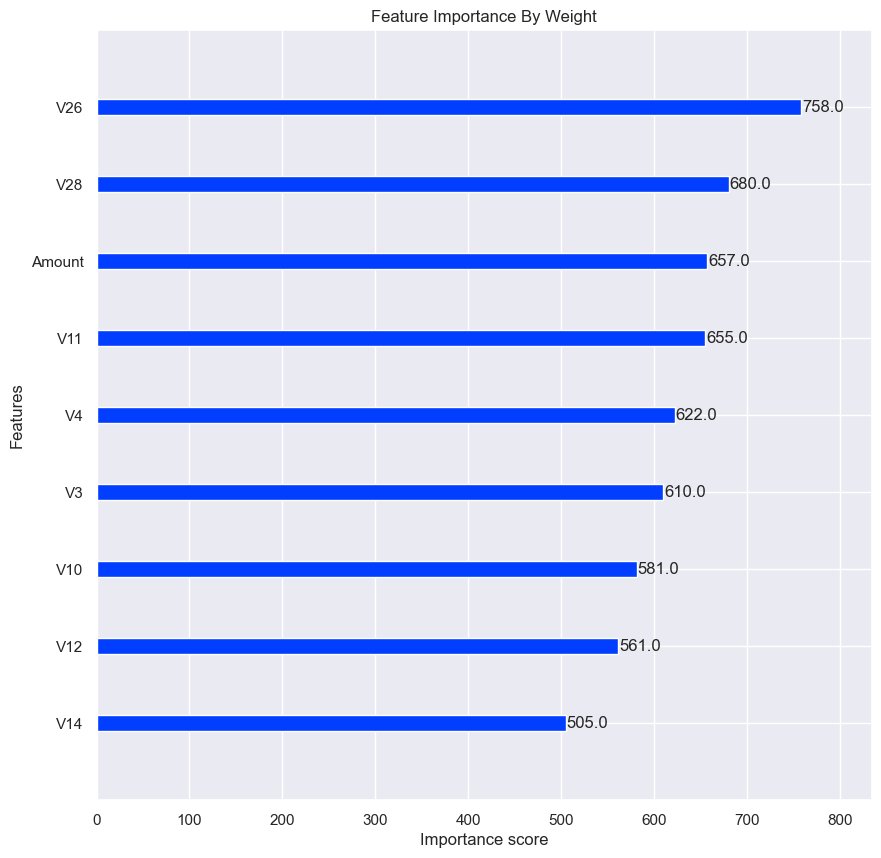

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="weight",
    title="Feature Importance By Weight"
)

plt.show()

**Importância das Variáveis (XGBoost — Gain)**

Como etapa final de interpretabilidade, foi analisada a importância das variáveis utilizando o critério **Gain**, fornecido nativamente pelo XGBoost.

O **Gain** mede o quanto uma variável contribui para reduzir o erro do modelo quando utilizada.

O gráfico evidencia que a variável **V14** se destaca de forma significativa, apresentando um ganho muito superior às demais. Isso indica que, embora outras variáveis também sejam utilizadas com frequência, **V14 é a que mais contribui para a redução do erro do modelo**.


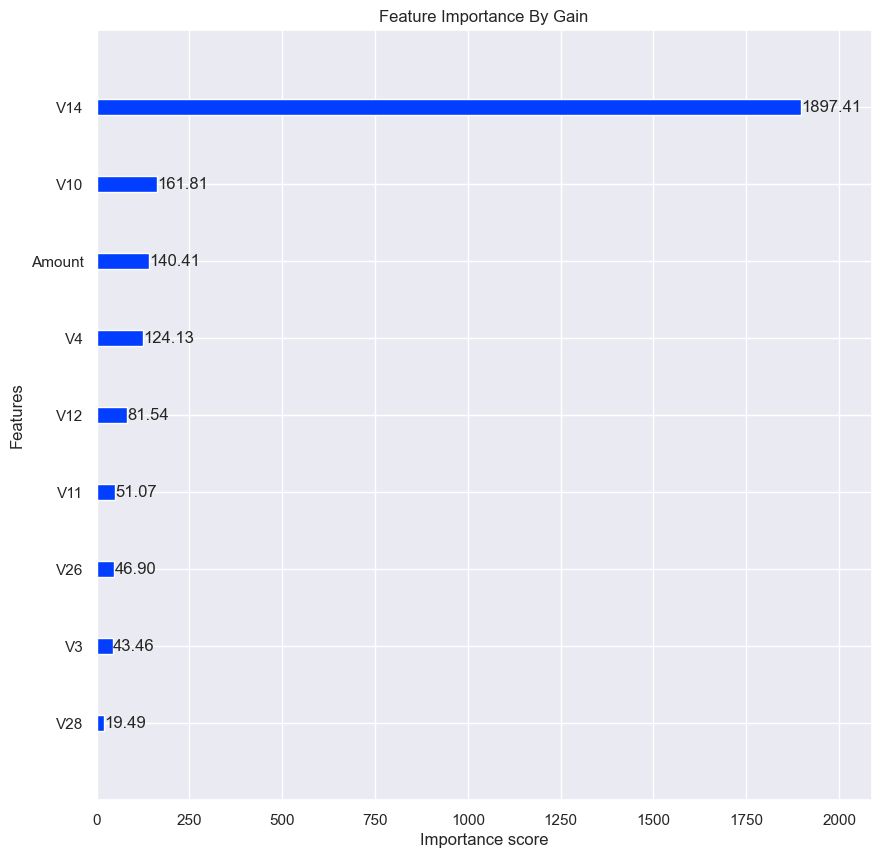

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="gain",
    title="Feature Importance By Gain",
    values_format="{v:.2f}"
)

plt.show()